## Iterator

In [5]:
x_list = [1, 2, 3]
x_iterator = iter(x_list)

next(x_iterator)

1

In [6]:
next(x_iterator)

2

In [7]:
next(x_iterator)

3

In [8]:
next(x_iterator)

StopIteration: 

## side talk - simple `iterator` class

In [14]:
class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt
        self.cnt = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.cnt == self.max_cnt:
            raise StopIteration()
            
        self.cnt += 1
        return self.cnt

### When `for` loop comes!

```python
1. iterator = iter([iterable]) -> calls __iter__
2. element = next([iterator]) -> calls __next__
```

In [20]:
a = [1, 2, 3]
a.__iter__()

In [21]:
a.__iter__().__next__()

1

At our `iterator` we call itself when `__iter__` is called!

In [13]:
iter(iter(x_iterator))

In [16]:
iterator = MyIterator(5)
for x in iterator:
    print(x)

1
2
3
4
5


### `Generator` also have `__iter__` when it's called as `function`!

- generator

In [29]:
def generator():
    for _ in range(5):
        yield 1

In [38]:
generator()

<generator object generator at 0x000001E3D6D2E148>

In [35]:
generator().__iter__()

<generator object generator at 0x000001E3D6D2E048>

In [36]:
for i in generator():
    print(i)

1
1
1
1
1


- not generator

In [31]:
def not_generator():
    for _ in range(5):
        return 1

In [37]:
not_generator()

1

In [34]:
not_generator().__iter__

AttributeError: 'int' object has no attribute '__iter__'

In [33]:
for i in not_generator():
    print(i)

TypeError: 'int' object is not iterable

## `DataLoader` Class

Add the following to the `__init__.py`

```python
from dezero.dataloaders import DataLoader
```

In [39]:
import math
import random
import numpy as np

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)
        
        self.reset()
        
    def reset(self):
        self.iteration = 0
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset))
        else:
            self.index = np.arange(len(self.dataset))
            
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration
            
        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size:(i + 1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]
        
        x = np.array([example[0] for example in batch])
        y = np.array([example[1] for example in batch])
        
        self.iteration += 1
        
        return x, y
    
    def next(self):
        return self.__next__()

## Using `DataLoader`

In [1]:
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

In [2]:
for epoch in range(max_epoch):
    for x, y in train_loader:
        print(x.shape, y.shape)
        break
        
    for x, y in test_loader:
        print(x.shape, y.shape)
        break

(10, 2) (10,)
(10, 2) (10,)


## `accuracy` function

`accuracy` returns **Variable** but calculate inside with **numpy** so this could not operator `back propagtaion`!

In [3]:
def accuracy(y_pred, y_true):
    y_pred, y_true = as_variable(y_pred), as_variable(y_true)
    
    y_pred = y_pred.data.argmax(axis=1).reshape(y_true.shape)
    result = (y_pred == y_true.data)
    acc = result.mean()
    
    return Variable(as_array(acc))

In [1]:
import numpy as np
import dezero.functions as F

y_pred = np.array([[0.2, 0.8, 0.],
                   [0.1, 0.9, 0.],
                   [0.8, 0.1, 0.1]])
y_true = np.array([1, 2, 0])

acc = F.accuracy(y_pred, y_true)
print(acc)

Variable(0.6666666666666666)


## `Spiral` dataset training with `DataLoader`

In [14]:
import math
import numpy as np

import dezero
from dezero import optimizers
from dezero import DataLoader

import dezero.functions as F
from dezero.models import MLP
from dezero.datasets import Spiral


max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = Spiral(train=True)
test_set = Spiral(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

In [15]:
epoch_list = []

train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []


for epoch in range(max_epoch):
    
    sum_loss, sum_acc = 0, 0
    
    for x, y in train_loader:
        y_pred = model(x)
        
        loss = F.softmax_cross_entropy(y_pred, y)
        acc = F.accuracy(y_pred, y)
        
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(y)
        sum_acc += float(acc.data) * len(y)
    
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)

    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    
    if epoch + 1 == 1 or (epoch + 1) % 30 == 0:
        print('epoch : {}'.format(epoch + 1))
        print('train loss {:.4f}, accuracy {:.4f}'.format(avg_loss, avg_acc))

    
    sum_loss, sum_acc = 0, 0
    
    with dezero.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            
            loss = F.softmax_cross_entropy(y_pred, y)
            acc = F.accuracy(y_pred, y)
            
            sum_loss += float(loss.data) * len(y)
            sum_acc += float(acc.data) * len(y)
            
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)            
    
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)

    if epoch + 1 == 1 or (epoch + 1) % 30 == 0:
        print('test loss: {:.4f}, accuracy: {:.4f}'.format(avg_loss, avg_acc))
    
    epoch_list.append(epoch + 1)    

epoch : 1
train loss 1.0944, accuracy 0.4033
test loss: 1.0468, accuracy: 0.3267
epoch : 30
train loss 0.7273, accuracy 0.5600
test loss: 0.7382, accuracy: 0.5433
epoch : 60
train loss 0.6122, accuracy 0.6633
test loss: 0.6169, accuracy: 0.6400
epoch : 90
train loss 0.3772, accuracy 0.8333
test loss: 0.3831, accuracy: 0.8300
epoch : 120
train loss 0.2361, accuracy 0.9200
test loss: 0.2573, accuracy: 0.9200
epoch : 150
train loss 0.1890, accuracy 0.9233
test loss: 0.2152, accuracy: 0.9067
epoch : 180
train loss 0.1539, accuracy 0.9500
test loss: 0.1814, accuracy: 0.9367
epoch : 210
train loss 0.1382, accuracy 0.9533
test loss: 0.1676, accuracy: 0.9467
epoch : 240
train loss 0.1251, accuracy 0.9500
test loss: 0.1583, accuracy: 0.9433
epoch : 270
train loss 0.1191, accuracy 0.9567
test loss: 0.1507, accuracy: 0.9533
epoch : 300
train loss 0.1082, accuracy 0.9667
test loss: 0.1458, accuracy: 0.9600


### Loss graph

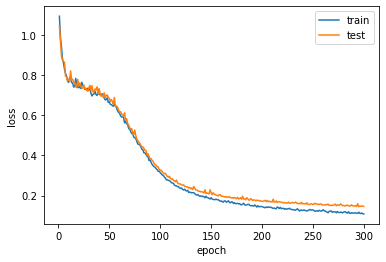

In [17]:
import matplotlib.pyplot as plt

plt.plot(epoch_list, train_loss_list, label='train')
plt.plot(epoch_list, test_loss_list, label='test')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

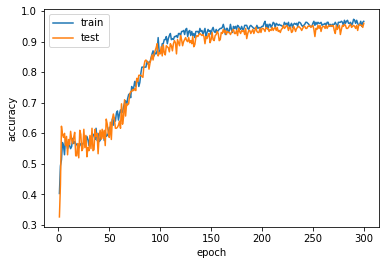

In [18]:
import matplotlib.pyplot as plt

plt.plot(epoch_list, train_acc_list, label='train')
plt.plot(epoch_list, test_acc_list, label='test')

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend()
plt.show()

### Decision boundary

In [14]:
x0s = []
x1s = []
ys = []
for i in range(len(train_set)):
    x_i, y_i = train_set[i]
    x0s.append(x_i[0])
    x1s.append(x_i[1])
    ys.append(y_i)
    
x0s, x1s, ys = np.array(x0s), np.array(x1s), np.array(ys)

In [44]:
xs = None
ys = None

for x, y in train_loader:
    if xs is None:
        xs = x
        ys = y
    else:
        xs = np.vstack((xs, x))
        ys = np.hstack((ys, y))
    
train_x0s, train_x1s, train_ys = xs[:, 0], xs[:, 1], ys

In [45]:
xs = None
ys = None

for x, y in test_loader:
    if xs is None:
        xs = x
        ys = y
    else:
        xs = np.vstack((xs, x))
        ys = np.hstack((ys, y))
    
test_x0s, test_x1s, test_ys = xs[:, 0], xs[:, 1], ys

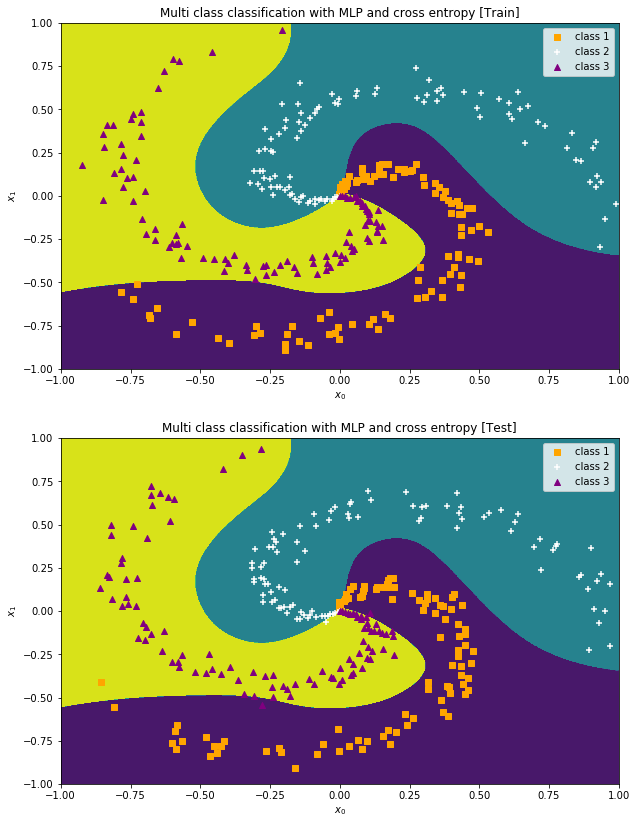

In [49]:
plt.figure(figsize=(10, 14))
plt.subplot(2, 1, 1)

x0_min, x0_max = -1, 1
x1_min, x1_max = -1, 1

XX0, XX1 = np.meshgrid(np.arange(x0_min, x0_max, (x0_max - x0_min)/1000),
                       np.arange(x0_min, x0_max, (x0_max - x0_min)/1000))
XS = np.array([XX0.ravel(), XX1.ravel()]).T

predict_y = model(XS)
YY = np.reshape(np.argmax(predict_y.data, axis=1), XX0.shape)


plt.contourf(XX0, XX1, YY)

colormap = plt.cm.get_cmap('rainbow', 3)
colors = ['orange', 'white', 'purple']
markers = ["s", "+", "^"]
for i in range(3):
    index = train_ys == i
    marker = markers[i]
    color = colors[i]
    plt.scatter(train_x0s[index], train_x1s[index],
                c=color, cmap=colormap, marker=marker, label=f"class {i + 1}")
    
plt.xlim(x0_min, x0_max)
plt.ylim(x1_min, x1_max)

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")

plt.title('Multi class classification with MLP and cross entropy [Train]')
plt.legend()


plt.subplot(2, 1, 2)

x0_min, x0_max = -1, 1
x1_min, x1_max = -1, 1

XX0, XX1 = np.meshgrid(np.arange(x0_min, x0_max, (x0_max - x0_min)/1000),
                       np.arange(x0_min, x0_max, (x0_max - x0_min)/1000))
XS = np.array([XX0.ravel(), XX1.ravel()]).T

predict_y = model(XS)
YY = np.reshape(np.argmax(predict_y.data, axis=1), XX0.shape)

plt.contourf(XX0, XX1, YY)

colormap = plt.cm.get_cmap('rainbow', 3)
colors = ['orange', 'white', 'purple']
markers = ["s", "+", "^"]
for i in range(3):
    index = test_ys == i
    marker = markers[i]
    color = colors[i]
    plt.scatter(test_x0s[index], test_x1s[index],
                c=color, cmap=colormap, marker=marker, label=f"class {i + 1}")

plt.xlim(x0_min, x0_max)
plt.ylim(x1_min, x1_max)

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")

plt.title('Multi class classification with MLP and cross entropy [Test]')
plt.legend()

plt.show()